<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install transformers --upgrade
#!pip install transformers -q
#!pip install wandb -q
!pip3 install --upgrade wandb
!pip3 install dill -q

In [3]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill
import tarfile
import json, gzip
import math
from typing import Optional, Union
import os

import wandb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#!cp '/root/optimizers.py' '/root/Projects/' # SSH
#!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP
#!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .


from optimizers import AdaFactor

In [5]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Thu Jul 23 12:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [ ]:
##!wandb login fac9119080ca108ca15c420ede645a5e6e79a07c

### First Log in 

In [6]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'Final_Project.ipynb'

#### Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading data**

In [ ]:
# fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

# tar = tarfile.open(fname, "r:")
# tar.extractall()
# tar.close()

In [ ]:
#!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
#!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [4]:
#path = '/home/jupyter/' # GCp
path = '/root/release/' # SSH
#path = "/content/drive/My Drive/Colab Notebooks/data/release/" # Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name + ".jsonl.gz") as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'dev')
#testset = read_data(path, 'test')

In [5]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
# test_data = get_data(testset)

In [9]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [10]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

The size of training dataset:(995041, 2) | validation dataset: (108837, 2)


In [6]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [12]:
train_data.isna().sum(), valid_data.isna().sum()

(text       0
 summary    0
 dtype: int64, text       0
 summary    0
 dtype: int64)

##### Preprocessing

In [7]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [8]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe['text'])):
        pragraph = len(paragraph.split())
        if pragraph < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    max_len, final_data = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, max_len

In [9]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 100,
          'min_summary_tokens': 0}

In [10]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


995041it [00:31, 31844.18it/s]


Done!


In [12]:
train_processed.to_pickle("./train_processed.pkl")

In [7]:
train_processed = pd.read_pickle("./train_processed.pkl")

In [13]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


108837it [00:03, 32442.50it/s]


Done!


In [14]:
valid_processed.to_pickle("./valid_processed.pkl")

In [8]:
valid_processed = pd.read_pickle("./valid_processed.pkl")

In [9]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951381 entries, 0 to 951380
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         951381 non-null  object
 1   summary      951381 non-null  object
 2   article_len  951381 non-null  int64 
 3   summary_len  951381 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 29.0+ MB


Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

In [28]:
doc_lengths

In [9]:
indices = np.where(train_processed['summary_len'] < 10)
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)
#train_processed.iloc[indices[0]]

In [30]:
#train_data.iloc[954753]['summary'] # '<ul>\n\t<li><b>£', 'Ø¨Ø§ Ø§Û\x8cÙ\x86 Ø§Ø\xadØ³Ø§Ø³ Ø¯Ø±Ù\x85Ø§Ù\x86Ø¯Ú¯Û\x8cØ\x8c Ø¨Ù\x87 Ù\x86Ø¸Ø±Øª Ù\x85Û\x8câ\x80\x8fØ±Ø³Ø¯ Ú©Ù\x87 ØªØ\xadØ±Û\x8cÙ\x85â\x80\x8fÙ\x87Ø§ Ø¯Ø§Ø±Ù\x86Ø¯ Ú©Ø§Ø± Ù\x85Û\x8câ\x80\x8fÚ©Ù\x86Ù\x86Ø¯'

In [32]:
train_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882676 entries, 0 to 882675
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         882676 non-null  object
 1   summary      882676 non-null  object
 2   article_len  882676 non-null  int64 
 3   summary_len  882676 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 26.9+ MB


In [33]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.0
0.7500     31.0
0.9000     44.0
0.9500     58.0
0.9900    141.0
0.9990    343.0
0.9999    663.0
Name: summary_len, dtype: float64

In [34]:
train_processed_data['article_len'].quantile([0.1,0.25,0.4,0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.1000      192.000
0.2500      322.000
0.4000      465.000
0.5000      574.000
0.7500      890.000
0.9000     1237.000
0.9500     1575.000
0.9900     3206.250
0.9990     8660.600
0.9999    23091.975
Name: article_len, dtype: float64

In [35]:
valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104147 entries, 0 to 104146
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         104147 non-null  object
 1   summary      104147 non-null  object
 2   article_len  104147 non-null  int64 
 3   summary_len  104147 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [37]:
valid_doc_lengths

In [10]:
inds = np.where(valid_processed['summary_len'] < 10)
#valid_processed.iloc[inds[0]]
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

In [5]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96581 entries, 0 to 96580
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         96581 non-null  object
 1   summary      96581 non-null  object
 2   article_len  96581 non-null  int64 
 3   summary_len  96581 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [6]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      571.000
0.7500      885.000
0.9000     1228.000
0.9500     1568.000
0.9900     3119.600
0.9990     8641.460
0.9999    22122.936
Name: article_len, dtype: float64

In [7]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.000
0.7500     31.000
0.9000     45.000
0.9500     60.000
0.9900    146.000
0.9990    364.000
0.9999    724.234
Name: summary_len, dtype: float64

In [11]:
art = 512 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 150# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:512, sum len:150


In [12]:
artV = 512 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 150# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:512, sum len:150


#### Creating Custom Dataset

In [13]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + self.dataframe.text[idx] + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + self.dataframe.summary[idx] + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


In [14]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Training Loop

In [15]:
def training(model, dataset_loader, optimizer, log_interval, regularizer, iteration=0):

    model.train()
    avg_loss = 0
    nItem = 0


    print(f'Start training for epoch: {iteration}')
    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))
 
    for idx, data_train in enumerate(tqdok):

        input_ids, source_mask, summary_ids, summary_mask = data_train

        input_ids = input_ids.to(device, dtype = torch.long)
        source_mask = source_mask.to(device, dtype = torch.float)
        summary_ids = summary_ids.to(device, dtype = torch.long)

        target_labels = summary_ids[:, :-1].contiguous()
        langm_labels = summary_ids[:, 1:].clone().detach()
        langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

        loss = output[0]

        loss.backward()
        optimizer.step()

        bs = input_ids.size(0)
        nItem += bs        
        
#         itr = iteration*(len(dataset_loader.dataset)//bs) + idx
#         optimizer.param_groups[0]['eps'] = eps_sched[itr]

        avg_loss += loss.item() * bs

        if idx%log_interval == 0:
                wandb.log({"Training Loss": loss.item()})
#         if idx % 5000 == 0:
#           print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
        
        losses.update(loss.item(), bs)
        tqdok.set_postfix(loss=losses.avg)
        
    avg_loss /= nItem
  
    return avg_loss, output


In [16]:
def validation(model, dataset_loader, regularizer):
    model.eval()

    eval_loss = 0
    nItem = 0

    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))

    with torch.no_grad():
        for idx, data_val in enumerate(tqdok):
            input_ids, source_mask, summary_ids, summary_mask = data_val

            input_ids = input_ids.to(device, dtype = torch.long)
            source_mask = source_mask.to(device, dtype = torch.float)
            summary_ids = summary_ids.to(device, dtype = torch.long)

            target_labels = summary_ids[:, :-1].contiguous()
            langm_labels = summary_ids[:, 1:].clone().detach()
            langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

            output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

            loss = output[0]

            bs = input_ids.size(0)
            nItem += bs

            eval_loss += loss.item()

            losses.update(loss.item(), bs)
            tqdok.set_postfix(loss=losses.avg)

    eval_loss /= nItem

    return eval_loss

In [19]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.


#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [17]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [18]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 2.108e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
t5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
class GatedFilterLayer(nn.Module):
  r"""
  Receives the keys from the encoder output.

  Returns:
    Output the values between [0,1]
   """

  def __init__(self, hidden_size_model):
    super(GatedFilterLayer, self).__init__()

    self.hidden_size_model = hidden_size_model
    self.projector = nn.Linear(hidden_size_model, 1)

    self.init_weights()

  def init_weights(self):
    initrange = 0.1
    self.projector.bias.data.zero_()
    self.projector.weight.data.uniform_(-initrange, initrange)

  def forward(self, last_hidden_encoder):
    proj = self.projector(last_hidden_encoder)
    gate = torch.sigmoid(proj)
    hidden_encoder = gate * last_hidden_encoder
    return hidden_encoder, gate

In [20]:
class EncoderModule(nn.Module):

  def __init__(self, T5ForGmodel=None, model_name = 't5-base'):
    super(EncoderModule, self).__init__()

    if T5ForGmodel is None:

      MODEL_NAME = model_name 
      if MODEL_NAME not in ['t5-base','t5-small','t5-large','t5-3b','t5-11b']:
        raise NameError('Name {} is not specified in T5 model names'.format(MODEL_NAME))

      T5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
      self.encoder_model = T5model.encoder
      dmodel = T5model.config.d_model
    else:
      self.encoder_model = T5ForGmodel.encoder
      dmodel = T5ForGmodel.config.d_model

    self.gatefilter = GatedFilterLayer(dmodel)


  def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, head_mask=None, output_hidden_states=False):
    
    if input_ids is None and inputs_embeds is None:
      raise ValueError("You have to specify either input_ids or input_embeds")
    
    if self.encoder_model.config.output_hidden_states or output_hidden_states:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask,
                                      output_hidden_states=True)
    else:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask)
    lst_enc_hidden = encoder_out[0]
    last_hidden_out, gate = self.gatefilter(lst_enc_hidden)

    last_hidden_out = (last_hidden_out, ) + encoder_out[1:] + (gate,)

    return last_hidden_out

In [21]:
class GatedT5ForSummurization(nn.Module):
  
  """
  Gated T5 with Language Model
  
  """

  def __init__(self,t5model=None, MODEL_NAME='t5-base'):
    super(GatedT5ForSummurization, self).__init__()

    self.encoder = EncoderModule(T5ForGmodel=t5model, model_name=MODEL_NAME)
    
    if t5model is None:
        self.decoder = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
    else:
        self.decoder = t5model

  def forward(self,input_ids=None, attention_mask=None,
              decoder_input_ids=None,decoder_attention_mask=None,
              decoder_past_key_value_states=None,use_cache=True,lm_labels=None,
              inputs_embeds=None,decoder_inputs_embeds=None, head_mask=None,
              output_hidden_states=False,lamda = 0.0,
             ):

    encoder_outputs = self.encoder(input_ids=input_ids, 
                                   attention_mask=attention_mask,
                                   inputs_embeds=inputs_embeds, 
                                   head_mask=head_mask,
                                   output_hidden_states=output_hidden_states)

    decoder_outputs = self.decoder(
            encoder_outputs=encoder_outputs,
            decoder_input_ids = decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            decoder_past_key_value_states = decoder_past_key_value_states,
            use_cache=use_cache,
            lm_labels = lm_labels,
            decoder_inputs_embeds=decoder_inputs_embeds,
            head_mask=head_mask)
        
    # Computing MLE Loss + L1 Norm Reg on LN weight
    if lm_labels is not None:

      Loss_MLE = decoder_outputs[0]
      #weight = self.encoder.gatefilter.projector.weight
      gate = encoder_outputs[-1]
      Loss_gate = torch.sum(gate.squeeze(-1))/(gate.shape[0]*gate.shape[1]) * lamda
      Loss = Loss_MLE + Loss_gate
    
      decoder_outputs = (Loss,) + decoder_outputs[1:]
      
    return decoder_outputs

  def generate(self,
               input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None):

    """
    All possible inputs receive by the generator
    For more details look @ huggingface documentation
    
        input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None
    """

    return self.decoder.generate(input_ids = input_ids, max_length = max_length, min_length = min_length,do_sample = do_sample,
        early_stopping = early_stopping,num_beams = num_beams,temperature= temperature,top_k = top_k,
        top_p = top_p, repetition_penalty = repetition_penalty,bad_words_ids = bad_words_ids,
        bos_token_id  = bos_token_id, pad_token_id  = pad_token_id,eos_token_id = eos_token_id,length_penalty= length_penalty,
        no_repeat_ngram_size = no_repeat_ngram_size,num_return_sequences = num_return_sequences,attention_mask = attention_mask,
        decoder_start_token_id = decoder_start_token_id,use_cache = use_cache
    )

In [22]:
model = GatedT5ForSummurization(t5model=t5model)


In [47]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [23]:
#@title Train, Validation and Test splits { run: "auto" }

columns = ["text","summary"]

X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)

In [24]:
X_train.head()

,text,summary
0,"HAMBURG, Germany, June 3 As he left the soccer...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 The National Security Agen...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc. s investors and...
3,BY A.J. BENZA and MICHAEL LEWITTES\n\nIf Simon...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie p...,POPEYE WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [25]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 2
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

In [44]:
Xtrain_trial = X_train.iloc[:50000]
Xvalid_trial = X_valid.iloc[:3600]

In [26]:
indices = np.random.permutation(len(X_train))
valind = np.random.permutation(len(X_valid))

ind = indices[:70000]
vind = valind[:5000]

Xtrain_trial = X_train.iloc[ind]
Xvalid_trial = X_valid.iloc[vind]

Xtrain_trial = Xtrain_trial.reset_index(drop=True)
Xvalid_trial = Xvalid_trial.reset_index(drop=True)

In [25]:
N_EPOCHS = 2
path = '/content/drive/My Drive/Colab Notebooks/best_model.pth'
pcle = '/content/drive/My Drive/Colab Notebooks/optimizer_state_dict.pkl'
#filename = open(pcle, 'wb')

In [27]:
def run(model,
        X_train, X_valid, 
        path=None,filename=None,
        lr= LEARNING_RATE):

    #best_loss = float('inf')
    #best_pp = float('inf')
    # WandB – Initialize a new run
    
    wandb.init(entity="jp-ishimwe", project="test-summaries")
    #wandb.init(entity="jp-ishimwe", project="document-summarization-test")
    #wandb.init(entity="jp-ishimwe", project="document-summarization-using-transformer")
#     wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          
    config.BATCH_SIZE = 6
    config.EVAL_BATCH_SIZE = 8
    config.N_EPOCHS = 3 
    config.LEARNING_RATE = lr
    config.SEED = 42               
    config.art_maxlen = art
    config.summary_maxlen = sum_
    config.Valid_art_maxlen = artV
    config.Valid_summary_maxlen = sumV
    config.log_interval = 500     # how many batches to wait before logging training status
    config.reg = 0.1081

    random.seed(config.SEED)
    np.random.seed(config.SEED)
    torch.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
    
    kwargs = {'max_article_tokens': config.art_maxlen,
                'max_summary_tokens': config.summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': config.Valid_art_maxlen,
                'max_summary_tokens': config.Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, config.BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, config.EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    optimizer = AdaFactor(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    wandb.watch(model, log="all")
    wandb.unwatch(model) 

#     maxiter = config.N_EPOCHS*(len(train_loader.dataset)//config.BATCH_SIZE)
#     eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))

    for epoch in range(config.N_EPOCHS):

        avg_loss, outputs = training(model, train_loader, optimizer, config.log_interval, regularizer=config.reg, iteration=epoch)
        print('\nValidation start:')
        eval_loss = validation(model, val_loader, regularizer=config.reg)

        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.4f}')
        print(f'Perplexity: {pp:.4f} | Eval loss: {eval_loss:.4f}')
        print("--------------")


        wandb.log({
            "Training Loss": avg_loss,
            "Perplexity ": pp,
            "Eval Loss": eval_loss})


        # Save model to wandb
#         torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model0.pt'))
        torch.save(model.state_dict(), '/root/Projectsmodel0.pt')


    return train_loss, perplexity, val_loss, outputs


    #     if pp < best_pp:
    #       best_pp = pp
    #       saving(path, epoch, avg_loss, model, pp, lr)
    #       dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
    #print(f'Best Perplexity: {best_pp}')
    #filename.close()

In [28]:
train_loss, perplexity, eval_loss, outputs = run(model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE)

  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 0


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:35<00:00,  4.01it/s, loss=1.52]


Epoch loss: 1.71
Perplexity: 1.209 | Eval loss: 0.19
--------------


  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 1


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:35<00:00,  4.01it/s, loss=1.49]


Epoch loss: 1.50
Perplexity: 1.205 | Eval loss: 0.19
--------------


  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 2


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:35<00:00,  4.01it/s, loss=1.48]


Epoch loss: 1.37
Perplexity: 1.204 | Eval loss: 0.19
--------------


In [34]:
gates = outputs[-1].squeeze(-1) 

In [35]:
gates.mean(dim=1,keepdim=True)

tensor([[0.1661],
        [0.2258],
        [0.3560],
        [0.3269]], device='cuda:0', grad_fn=<MeanBackward1>)

In [36]:
values, _ = gates.max(dim=1,keepdim=True)
values

tensor([[0.5192],
        [0.5296],
        [0.5251],
        [0.5483]], device='cuda:0', grad_fn=<MaxBackward0>)

In [37]:
vals, _ = gates.min(dim=1,keepdim=True)
vals

tensor([[0.0292],
        [0.0303],
        [0.1157],
        [0.0288]], device='cuda:0', grad_fn=<MinBackward0>)

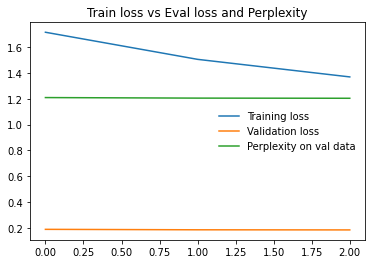

In [29]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [38]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=1,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.decoder.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
pretrained = False

if pretrained:    

    model = .... # first initialize the model and optimizer

    #optimizer = ... # optimizer then,
    infile = open(pcle,'rb')
    optimizer = pickle.load(infile)
    infile.close()

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [61]:
!ls /root/Projects


Final_Project.ipynb	     Wheat_rust_classification.ipynb
README.md		     model.pt
T5_ftransfer_learning.ipynb  valid_processed.pkl
Untitled.ipynb		     wandb


In [76]:
model.load_state_dict(torch.load('/root/Projectsmodel0.pt'))
model = model.to(device)

In [23]:
#model = torch.load('/root/Projects/model.pt')

In [77]:
ivind = valind[5000:6000]

X_trial = X_valid.iloc[ivind]

Xtest_trial = X_trial.reset_index(drop=True)

argsval = {'max_article_tokens': 512,
                'max_summary_tokens': 150
             }
    
    
val_loader  = get_dataloader(Xtest_trial, 6,valid='valid', **argsval)

In [78]:
%time results = generator(model, val_loader)

CPU times: user 16min 14s, sys: 20.3 s, total: 16min 35s
Wall time: 13min 10s


#### Visualizing examples

**Example 1**

In [79]:
Xtest_trial.iloc[0,:]['text']

'Jemima West stars as a country innocent blackmailed into prostitution in 1871 Paris in Maison Close. It is one of several unusual French series that are hard to find in the United States.\n\nIt may be a small world, but it s remarkable how many barriers remain to easy viewing.\n\nThe first three seasons of Spiral, the English title for Engrenages, are available on Netflix with English subtitles.\n\nThere are various English language adaptations under discussion for Spiral, as well as Les Revenants and Maison Close. But there s no guarantee that they will be made, let alone measure up.\n\nThe Internet offers only spotty, and often illegal, downloads of individual episodes, so the easiest way actually to see one of these series is quite complicated. A few American DVD players are multiregion some single region players can be reprogrammed to play foreign DVDs or viewers can buy a universal player. Some DVDs can be played on a computer, but most computers with disc players require a chang

In [80]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'Four French TV dramas serve up the most common themes crime, war, sex and the occult in fresh and unexpected ways.'

In [81]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'Television s streaming Internet resources often not a simple way, but if it ll always at. A better way for to find ways that more creative approaches faster ideas than with fewer less bler'

**Example 2**

In [82]:
Xtest_trial.iloc[1,:]['text']

'When you think of Malibu, you think of Hollywood s rich and famous, of blue waters, sandy beaches and an idyllic lifestyle. Right? Well, partly right. Along with the rich and famous, there is a heavy dose of hippie and surfer culture. And while most of the city is very safe for visitors and locals alike, there are some areas to avoid in Malibu. What follows is a run down of safe areas and dangerous places in Malibu.\n\nFirst, some facts and figures. Malibu is a relatively small city with a population of fewer than 15,000, but it receives over a million visitors a year. This isolated city is sandwiched between the Pacific Ocean and the Santa Monica mountains.\n\nCrime rates are relatively low, with the likelihood of someone being the victim of violent crime in Malibu only 1 in 305, compared to the rest of California which is 1 in 178 according to the website,\n\nCompared to the rest of California, then, Malibu is a safe city with fewer dangerous places than most urban areas.\n\nBy safe

In [83]:
print("Actual summary:")
results['golden_summary'][1]

Actual summary:


'Alamy When you think of Malibu, you think of Hollywood s rich and famous, of blue waters, sandy beaches and an idyllic lifestyle. Right? Well, partly right. Along with the rich and famou'

In [84]:
print('Generated summary:')
results['generated_summary'][1]

Generated summary:


'Malibu has a higher risk of burglary being the most frequent and very single entry to be must. as two well double multiple fatal fatal fatal fatal, in both'

**Example 3**

In [85]:
Xtest_trial.iloc[3,:]['text']

'NFL players can be their own worst enemies when it comes to playing with serious injuries, says Boomer Esiason. The NFL should investigate how injured Dallas Cowboys quarterback Tony Romo was medically cleared to play with a fractured rib and punctured lung against San Francisco 49ers Sunday, he says.\n\nUSA TODAY caught up with the CBS and MSG Network analyst as he and WFAN radio partner Craig Carton celebrated the one year anniversary of their Boomer and Carton show on MSG in New York Wednesday night.\n\nWe asked the former Cincinnati Bengals QB, and 1988 NFL MVP, about a number of topics, including Romo s gutsy comeback and whether the New York Giants faked injuries against the St. Louis Rams Monday night \n\nYou ve indicated on MSG WFAN you don t think the Cowboys did the right thing with Romo. Explain.\n\nI thought we were supposed to have people on the sideline that were supposed to protect the players from themselves. Because we are our own worst enemy. Case in point, Tony Romo

In [86]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'Boomer Esiason asks Why the hell isn t NFL investigating how injured Tony Romo was cleared to play with fractured rib and punctured lung'

In [87]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'NFL players can walked a mile in the manandhe probably walking, if I maybe he almost his mind, The back of his mind, what things.'

**Example 4**

In [88]:
Xtest_trial.iloc[4,:]['text']

'This year, the German government offered 4.5 billion euros 6.7 billion in a bridge loan and loan guarantees if G.M. sold the majority of its European business to a consortium led by the Canadian car parts maker Magna International and the Russian lender Sberbank.\n\nAt the time, it was reported that Germany favored the Magna consortium s bid over a competing offer led by a United States private equity firm because Magna had promised to protect German jobs. That, in turn, led other countries where G.M. has plants to complain that Germany was protecting its own interests at the expense of workers in other countries.\n\nBefore the meeting Monday, the German economics minister, Rainer Br derle, warned that any decision to grant subsidies to G.M. in Europe might breach European Union rules over state aid. We do not see that the German taxpayer is prepared to be the rich uncle, Mr. Br derle said on ARD public television in Germany.\n\nThe deputy economics minister in Germany, Jochen Homann,

In [89]:
print("Actual summary:")
results['golden_summary'][4]

Actual summary:


'The chief of G.M. s European operations is seeking German help in restructuring Opel, but the country s economics minister said taxpayers should not be expected to play the rich uncle.'

In [90]:
print('Generated summary:')
results['generated_summary'][4]

Generated summary:


'G.M s European meetings in a fran, if esc and pac appro? 0 978 of the n'

**Example 5**

In [91]:
Xtest_trial.iloc[5,:]['text']

'Maintenance work by American Airlines on hundreds of jets was so sloppy that it posed a safety risk a lapse that forced the carrier to ground many of its planes and strand hundreds of thousands of passengers last month, according to a report by federal regulators released yesterday.\n\n Left uncorrected, the workmanship errors would have increased the odds that a plane would have experienced arcing, smoke, or fire problems that have caused serious incidents and fatal accidents in the past, the Federal Aviation Administration said in the report.\n\nRegulators added that the poor quality of the work on bundles of wires in the airline s 367 MD 80 jets raised the specter of a cumulative safety risk. \n\nAmerican Airlines, in its own assessment of the situation, said that at no time was there a safety of flight issue. It blamed the four days of groundings that ended April 12 on a communication failure within the FAA and between the FAA and American. \n\nA spokesman for the carrier took exc

In [92]:
print("Actual summary:")
results['golden_summary'][5]

Actual summary:


'Maintenance work by American Airlines on hundreds of jets was so sloppy that it posed a safety risk a lapse that forced the carrier to ground many of its planes and strand hundreds of thousands of passengers last month, according to a report by federal regulators released yesterday.'

In [93]:
print('Generated summary:')
results['generated_summary'][5]

Generated summary:


'Maintenance work had been a part of safety rule designed to mitigate the risks, aims prevent dangers for sparking fires and explosion warnings.'

**Example 6**

In [94]:
Xtest_trial.iloc[6,:]['text']

'An Ohio woman was charged with stealing her son s income tax refunds and U.S. Army paychecks while he was serving in Iraq and Afghanistan, the Canton Repository newspaper reports.\n\nPolice say Jennifer Fletcher, 42, was charged with identity fraud, forgery and two counts of theft. She was arrested in Brewster, in northeast Ohio, while driving what police said was a stolen vehicle.\n\nLawrence Township Police Chief Mark Brink said Monday that Fletcher is suspected of withdrawing about 16,000 from the account of her son, Scott Davis, while he was serving overseas in 2010 and 2011, the Associated Press reports.\n\nShe is also accused of depositing nearly 1,400 of Davis state and federal income tax refunds into her account.\n\nThe Repository says court records show Fletcher used her son s personal information to obtain checks in his name, then cashed them after forging his signature.'

In [95]:
print("Actual summary:")
results['golden_summary'][6]

Actual summary:


'An Ohio woman is accused of stealing her son s income tax refunds and U.S. Army paychecks while he was serving overseas.'

In [96]:
print('Generated summary:')
results['generated_summary'][6]

Generated summary:


'An Ohio man was serving in Iraq and Afghanistan, Associated Press reports. Court records show Fletcher used his son s personal information to obtain checks in his name'

**Example 7**

In [97]:
Xtest_trial.iloc[7,:]['text']

'4 10 p.m. NBA Jam Session, Ernest N. Morial Convention Center\n\n4 10 p.m. NBA Jam Session\n\n5 8 p.m. All Star Celebrity Game, Ernest N. Morial Convention Center\n\n8 10 p.m. T Mobile Rookie Challenge and Youth Jam, New Orleans Arena TNT \n\n9 a.m. 10 p.m. NBA Jam Session\n\n11 11 45 a.m. NBA East All Star practice, Ernest N. Morial Convention Center\n\n12 30 1 15 p.m. NBA West All Star practice, Ernest N. Morial Convention Center\n\n2 p.m. D League All Star Game, Ernest N. Morial Convention Center NBA TV \n\n7 10 p.m. All Star Saturday Night, New Orleans Arena TNT \n\nHaier Shooting Stars Chicago Chris Duhon, Candice Dupree, B.J. Armstrong. Detroit Chauncey Billups, Swin Cash, Bill Laimbeer. Phoenix Amare Stoudemire, Cappie Poindexter, Eddie Johnson. San Antonio Tim Duncan, Becky Hammon, David Robinson.\n\nPlayStation Skills Challenge Jason Kidd, New Jersey Chris Paul, New Orleans Dwyane Wade, Miami Deron Williams, Utah.\n\nFoot Locker Three Point Shootout Kobe Bryant, Los Angeles L

In [98]:
print("Actual summary:")
results['golden_summary'][7]

Actual summary:


'Even when he can t play, Kevin Garnett feels compelled to do something to help his Boston Celtics win. So he talks. There s a voice in the back of the bus, and the plane, every day, Celtics center Scot Pollard said, and it s always the same guy.'

In [99]:
print('Generated summary:')
results['generated_summary'][7]

Generated summary:


'Even when he canandno play, K.G. Garnett at NBA All Star Games and has the same guy in Boston for Celtics center Scot Pollard of his mind all to him every a day three p.m with 10 P noon e Saturday 2:30 9 h on 10 2 3:30 00 900 before 3 59 or 7 ten'

**Example 8**

In [100]:
Xtest_trial.iloc[8,:]['text']

'Read MoreWhy hackers want your health care data\n\nIn order to gain an edge over the competition, Fitbit will need to build out its platform for third party applications, Maguire said.\n\n The test in the public markets will be their ability to execute over the next few quarters, he added.\n\nRead MoreJawbone files lawsuit against rival Fitbit.again\n\nBut investors may want to avoid the stock completely, according to Trip Chowdhry, managing director of equity research at Global Equities Research.\n\nFitness trackers from Xiaomi are priced at less than 20 while Fitbit s gadgets are closer to 100 or more. Consumers are highly price sensitive, Chowdhry said.'

In [101]:
print("Actual summary:")
results['golden_summary'][8]

Actual summary:


'Fitbit, the NYSE s newest member, faces some serious challenges, analysts tell CNBC.'

In [102]:
print('Generated summary:')
results['generated_summary'][8]

Generated summary:


'awbone filed lawsuit against rival Fitbit Inc. But investors warn they may wantdhry, Chowhery saidchowdharry says highs'

**Example 9**

In [103]:
Xtest_trial.iloc[9,:]['text']

'December 19, 2013 3 15pm\n\nSuch is the Yankees mystique and aura that even in a year when the club missed the playoffs a wild, woolly and swashbuckling October that ended with a parade through Boston their affiliates dominated a sizable chunk of the baseball headlines.\n\nFrom their most revered player leaving the sport to their best player leaving for Seattle, to the many turns of the Alex Rodriguez saga, the pinstripes are well represented in our top MLB stories of 2013.\n\nA professional sport has never seen the sort of player versus league battle that Alex Rodriguez has engaged in with Major League Baseball. While appealing his 211 game suspension for alleged illegal performance enhancing drug use and obstruction, A Rod hired his own team of lawyers and investigators and impressively muddied up MLB while also waging battle with the Yankees even as he played for them. The ruling should arrive from independent arbitrator Fredric Horowitz in January, yet if the news is bad for A Rod

In [104]:
print("Actual summary:")
results['golden_summary'][9]

Actual summary:


'Such is the Yankees mystique and aura that even in a year when the club missed the playoffs a wild, woolly and swashbuckling October that ended with a parade'

In [105]:
print('Generated summary:')
results['generated_summary'][9]

Generated summary:


'Such a run paced tour of the group who s e a glimpse behind the team s owning r 0 f 59 top stories from on a snap 111, as the clubhouse chemistry and the group whose leadership with the group mates of the former staff at stra'

**Example 10**

In [106]:
Xtest_trial.iloc[15,:]['text']

'You re killing your baby. This can t be healthy. Is that safe? \n\nand more heard from Instagram commenters about working out during their pregnancies, despite their insistence that everything has been\n\nand recommended by obstetricians, says Joanne Stone, MD, the director of Maternal Fetal Medicine at Mount Sinai Health System.\n\nCouldn t feel better, my body, energy and mobility is allowing me to continue to stay active. Yes I understand that this may shock others. And it s because my lifestyle and bodies condition coming into my pregnancy was not like theirs and that is the honest truth. I would train 8 sessions per week, work 80 hours per week, my alarm is 4am Mon Sat and every 2nd Sun, I clock off around 8 30pm Mon Fri, I sleep on average 4 5hrs a night, I eat 80 20, 80 really wholesome and healthy and 20 is usually little tasty treats but it s also not always the case as i don t always feel like rubbish. My body isn t a pussy excuse my language I have never treated it soft, I 

In [107]:
print("Actual summary:")
results['golden_summary'][15]

Actual summary:


'Chontel Duncan, Hannah Polites and more were accused of harming their babies but is that really the case?'

In [108]:
print('Generated summary:')
results['generated_summary'][15]

Generated summary:


'You aandrs 2 3 jobs at one time At Simon He, I t always Sie. If you it'

### Performance

In [71]:
!pip3 install rouge
from rouge import Rouge

In [72]:
!pip3 install rouge-score tqdm
from rouge_score import rouge_scorer, scoring

In [109]:
from typing import Dict

def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [110]:
get_score(results)

{'rouge1': 0.15632342218232836,
 'rouge2': 0.03142968029258024,
 'rougeL': 0.11805405679218137}

In [ ]:
{'rouge1': 0.3251555298232545,
 'rouge2': 0.17724507880716306,
 'rougeL': 0.2734545655096767}

In [111]:
rouge = Rouge()

score = rouge.get_scores(results['generated_summary'], results['golden_summary'], avg=True)
{key: val['f'] for key, val in score.items()}

{'rouge-1': 0.13611250738900807,
 'rouge-2': 0.027229727728854826,
 'rouge-l': 0.12265045246612152}

##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])